In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
import tensorflow as tf
from tensorflow.keras.models import Model, load_model
from tensorflow.keras.utils import plot_model
from tensorflow.keras.layers import *
import tensorflow_addons as tfa
import pickle

print(tf.__version__)

2.6.3


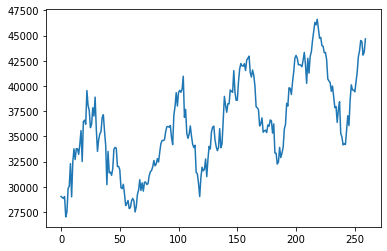

In [2]:
df = pd.read_excel('train.xlsx', parse_dates=True, dtype={'Product A (historical)': int})
df.drop(['Workweek'], axis=1, inplace=True)
df.columns = ['value']
data = df.values
plt.plot(data)

In [3]:
def normalize_series(data, min, max):
    data = data - min
    data = data / max
    return data

def windowed_dataset(series, batch_size=16, n_past=52, n_future=1, shift=1):
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(size=n_past + n_future, shift=shift, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(n_past + n_future))
    ds = ds.map(lambda w: (w[:n_past], w[n_past:]))
    return ds.batch(batch_size).prefetch(-1)

batch_size = 16
n_past = 58 * 3  # look back 3 periods
n_future = 1
shift = 1

# scaler = MinMaxScaler(feature_range=(0, 1))  # scale between 0 and 1
# scaler.fit(data)
with open('scaler.pickle', 'rb') as f:
    scaler = pickle.load(f)
scaled_data = scaler.transform(data)
SPLIT_TIME = 26*7  # take first 3.5 year as train, last year as val
x_train = scaled_data[:SPLIT_TIME]
x_val = scaled_data[SPLIT_TIME:]
train_set = windowed_dataset(series=scaled_data, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)
valid_set = windowed_dataset(series=x_val, batch_size=batch_size, n_past=n_past, n_future=n_future, shift=shift)

In [4]:
xIn = Input(shape=(n_past, 1))  # take in arbitrary number of time steps and 1 feature
x = Flatten()(xIn)
x = Dense(128)(x)
x = tfa.activations.mish(x)
x = Dense(128)(x)
x = tfa.activations.mish(x)
x = Dense(64)(x)
x = tfa.activations.mish(x)
x = Dense(32)(x)
x = tfa.activations.mish(x)
xOut = Dense(n_future)(x)

model = Model(inputs=xIn, outputs=xOut)
callbacks = [tf.keras.callbacks.ReduceLROnPlateau(monitor='mae', factor=0.1, patience=35, verbose=1),
             tf.keras.callbacks.EarlyStopping(monitor='mae', patience=60, verbose=1, restore_best_weights=True)]

opt = tfa.optimizers.RectifiedAdam(1e-3)
opt = tfa.optimizers.Lookahead(opt)
model.compile(loss='mae', optimizer=opt, metrics=['mae'])
model.summary()
plot_model(model, to_file='model.png', show_shapes=True)
model.fit(train_set, epochs=2000, batch_size=16, shuffle=True, callbacks=callbacks, verbose=1, use_multiprocessing=True, workers=16)

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 174, 1)]     0                                            
__________________________________________________________________________________________________
flatten (Flatten)               (None, 174)          0           input_1[0][0]                    
__________________________________________________________________________________________________
dense (Dense)                   (None, 128)          22400       flatten[0][0]                    
__________________________________________________________________________________________________
tf.convert_to_tensor (TFOpLambd (None, 128)          0           dense[0][0]                      
______________________________________________________________________________________________

244.0655


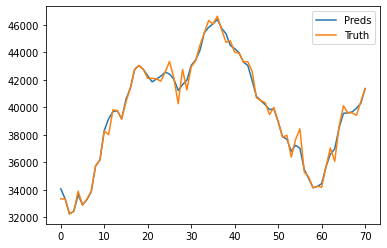

In [7]:
def model_forecast(models, series, window_size, batch_size):
   ds = tf.data.Dataset.from_tensor_slices(tf.squeeze(series))
   ds = ds.window(window_size, shift=1, drop_remainder=True)
   ds = ds.flat_map(lambda w: w.batch(window_size))
   ds = ds.batch(batch_size, drop_remainder=True).prefetch(1)
   forecast = []
   for model in models:
    forecast += [model.predict(ds)]
   return np.mean(forecast, axis=0)

models = [model]
#models = [load_model('model_1040_good_line')]
#models += [load_model('model_1015')]
#models += [load_model('model_1116_good_line')]
preds = model_forecast(models, scaled_data, n_past, batch_size)
preds = scaler.inverse_transform(preds)
preds = preds[SPLIT_TIME - n_past:-1, 0]
# preds = np.delete(preds, [0])  # remove first step

x_valid = scaler.inverse_transform(x_val)
x_valid = np.squeeze(x_valid[:preds.shape[0]])
result = tf.keras.metrics.mean_absolute_error(x_valid, preds).numpy()
print(result)

'''
244.0655 (dense with ranger and mish overfit on full data, look back 174 (58 * 3))
269.45175 (dense with ranger and mish overfit on full data, look back 156)
291.60852 (dense with ranger and mish overfit on full data, look back 52)
347.36412 (dense with ranger and mish overfit on full data, look back 104, plot better than 291)
428.38068 (dense with ranger and mish overfit on full data)
960.77594 (didnt save)
969.8429 (dense with ranger and mish)
973.58 (dense only)
1015.6262
1040.1976 (good line)
1116.5305 (good line)
1155.5602 (good line)
'''

plt.plot(preds, label='Preds')
plt.plot(x_valid, label='Truth')
plt.legend()
plt.show()

In [8]:
model.save('model_244_dense')

INFO:tensorflow:Assets written to: model_244_dense\assets
